# Directed Independent Research: Domestic Ideology and UN Alignment (1992–2020)

**Author:** Hieu Tran  
**Last Updated:** October 26, 2025

---

## Overview
This notebook explores the relationship between domestic political ideology and foreign policy alignment in United Nations General Assembly (UNGA) voting from 1992 to 2020.  
It uses machine learning, specifically a `RandomForestRegressor`, to model how domestic political factors, such as executive ideology and institutional checks, predict countries’ UNGA ideal point estimates.

---

## Objectives
- Load a preprocessed dataset containing:
  - **Database of Political Institutions (DPI)**: Executive ideology, institutional checks, election indicators  
  - **UNGA Ideal Points**: Quantified foreign policy alignment scores  
- Train a `RandomForestRegressor` to predict UNGA ideal points (`idealpointfp`) using domestic political variables  
- Evaluate model performance on test data (2016–2020), trained on 1992–2015  
- Visualize feature importances to identify which domestic factors most influence foreign policy alignment  

---

## Data Sources
- **Database of Political Institutions (DPI)** — [Inter-American Development Bank](https://www.iadb.org/en/knowledge-resources/research-idb/research-datasets/database-political-institutions)  
- **UNGA Ideal Points** — [Erik Voeten (Harvard Dataverse)](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LEJUQZ)

---

## Data Inputs
- **File:** `dpi2020_mod.csv`  
- **Path:** `/data`  
- **Description:** Contains country-year observations for advanced democracies, including executive ideology (`execrlc`), institutional checks (`checks`), and corresponding UNGA ideal point estimates (`idealpointfp`).

---

## Dependencies
- Python ≥ 3.10  
- pandas, scikit-learn, matplotlib  


## 1. Project Setup

We begin by importing libraries, setting paths, and defining configuration variables.


In [1]:
import os, math
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [2]:
CSV_PATH = "../data/dpi2020_mod.csv"

START_YEAR = 1992
END_YEAR   = 2020

TRAIN_END  = 2015      # inclusive
TEST_START = 2016      # inclusive


## 2. Load Dataset and Initial Cleaning

We load the preprocessed dataset (`dpi2020_mod.csv`), which includes both domestic political indicators  
(from the Database of Political Institutions) and UNGA ideal points.  
We then clean coding artifacts such as `0` or `-999` where they represent missing data.


### Dataset Variables

The dataset combines variables from the **DPI** (updated 2023) and the **UNGA ideal point dataset** (updated 2025).  
Each observation represents a **country-year** between 1992 and 2020.

| Variable | Description |
|-----------|--------------|
| **country** | Country name |
| **year** | Observation year (1992–2020) |
| **execrlc** | Executive’s ideological orientation — *1 = Left, 2 = Center, 3 = Right, 0 = Missing* |
| **checks** | Institutional checks and balances; higher values indicate more independent veto players and stronger constraints on the executive |
| **system** | Political system — *1 = Parliamentary, 2 = Assembly-Elected President, 3 = Presidential* |
| **legelec** | Indicator for legislative election year (*1 = election held, 0 = no election*) |
| **exelec** | Indicator for executive election year (*1 = election held, 0 = no election*) |
| **idealpointfp** | Country’s estimated UNGA ideal point, capturing foreign policy alignment (higher = more Western/liberal-aligned, lower = more sovereignty-oriented) |

**Note:**  
In DPI coding, `0` indicates missing data; these are converted to `NaN` for analysis.


In [3]:
df = pd.read_csv(CSV_PATH)

# Filter by year
df = df[(df["year"] >= START_YEAR) & (df["year"] <= END_YEAR)].copy()

# Handle missing data (to NaN)
for col in ["execrlc", "system"]:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

# Preview (first 20 datapoints)
preview_cols = [c for c in ["country","year","execrlc","checks","system","legelec","exelec","idealpointfp"] if c in df.columns]

print(df[preview_cols].head(20))


    country  year  execrlc  checks  system  legelec  exelec  idealpointfp
0   Albania  1992      1.0     2.0       1        1       0      0.978085
1   Albania  1993      3.0     2.0       1        0       0      0.945894
2   Albania  1994      3.0     2.0       1        0       0      1.054056
3   Albania  1995      3.0     2.0       1        0       0      0.985947
4   Albania  1996      3.0     2.0       1        1       0      1.189963
5   Albania  1997      3.0     2.0       1        1       0      1.058038
6   Albania  1998      1.0     2.0       1        0       0      1.115533
7   Albania  1999      1.0     2.0       1        0       0      0.990348
8   Albania  2000      1.0     2.0       1        0       0      1.303230
9   Albania  2001      1.0     2.0       1        1       0      1.333558
10  Albania  2002      1.0     2.0       1        0       0      1.066275
11  Albania  2003      1.0     2.0       1        0       0      1.162230
12  Albania  2004      1.0     2.0    

## 3. Feature Engineering: Elections and Ideological Change

This section derives key analytical variables:

- **relevant_elec:** uses executive elections in presidential systems and legislative elections otherwise  
- **ideology_changed:** detects when a government’s ideology differs from the previous year  
- **years_since_elec / years_until_next_elec:** track term timing  
- **post_elec_1y–3y:** flags for the first three years after an election  
- **delta_idealpoint:** year-to-year change in UN alignment

In [4]:
# Sort
df = df.sort_values(["country", "year"]).reset_index(drop=True)

# Define relevant election based on system type
# Presidential (3) → use executive elections
# Parliamentary (1) or Assembly-Elected (2) → use legislative elections
df["relevant_elec"] = np.where(
    df["system"] == 3, df.get("exelec", 0),
    df.get("legelec", 0)
).astype(int)

# Handle missing system data gracefully
df["relevant_elec"] = df["relevant_elec"].fillna(0)

# Mark any election years
df["election_any"] = (df["relevant_elec"] == 1).astype(int)

# Lag ideology and idealpoint by one year (within each country)
df["execrlc_lag1"] = df.groupby("country")["execrlc"].shift(1)
df["idealpoint_lag1"] = df.groupby("country")["idealpointfp"].shift(1)

# Did ideology change compared to previous year?
df["ideology_changed"] = (df["execrlc"] != df["execrlc_lag1"]).astype(float)

# Identify actual election years (based on the unified variable)
df["election_year"] = df["year"].where(df["election_any"] == 1)

# Years since / until election
df["last_elec_year"] = df.groupby("country")["election_year"].ffill()
df["next_elec_year"] = df.groupby("country")["election_year"].bfill()

df["years_since_elec"] = df["year"] - df["last_elec_year"]
df["years_until_next_elec"] = df["next_elec_year"] - df["year"]

# Post-election dummy variables for 1–3 years after
for k in [1, 2, 3]:
    df[f"post_elec_{k}y"] = ((df["years_since_elec"] >= 1) & (df["years_since_elec"] <= k)).astype(int)

# (optional) make the target the change in ideal point from the previous year
df["delta_idealpoint"] = df["idealpointfp"] - df["idealpoint_lag1"]


## 4. Prepare Features and Target
After feature engineering, we now build the feature matrix (`X`) and target variable (`y`).  
If `USE_DELTA` is set to `True`, we predict *changes* in UN alignment; otherwise, we predict the alignment *level* itself.

In [5]:
USE_DELTA = False  # Set True to predict delta_idealpoint

if USE_DELTA:
    df = df.dropna(subset=["delta_idealpoint"]).copy()

df = df.reset_index(drop=True)

## 5. Build Feature Matrix and Target Vector
We include core domestic political variables (ideology, checks, system) and our election-related features (years since/until election, post-election windows, etc.).


In [6]:
# Build X and y from the resulting df
feature_cols = [
    "execrlc","checks","system",
    "ideology_changed","years_since_elec","years_until_next_elec",
    "post_elec_1y","post_elec_2y","post_elec_3y","year"
]
X = df[feature_cols].astype(float).copy()
y = (df["delta_idealpoint"] if USE_DELTA else df["idealpointfp"]).astype(float).copy()

## 6. Split Train and Test Sets
We split the dataset by year (train ≤ 2015, test ≥ 2016) to simulate out-of-sample prediction.


In [7]:
train_mask = (df["year"] <= TRAIN_END)
test_mask  = (df["year"] >= TEST_START)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test,  y_test  = X.loc[test_mask],  y.loc[test_mask]


print(len(df), X.shape, y.shape)
print("Train/Test:", X_train.shape, X_test.shape)

# Save modeling frames
X_train.to_csv("../data/X_train_single.csv", index=False)
y_train.to_csv("../data/y_train_single.csv", index=False)
X_test.to_csv("../data/X_test_single.csv", index=False)
y_test.to_csv("../data/y_test_single.csv", index=False)


841 (841, 10) (841,)
Train/Test: (696, 10) (145, 10)


## 8. Train Random Forest Model

We use a `RandomForestRegressor` to capture nonlinear relationships between domestic factors  
and UNGA alignment.  The ensemble approach helps reduce overfitting and interpret variable importance.


In [8]:
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


,n_estimators,600
,criterion,'squared_error'
,max_depth,None
,min_samples_split,4
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 9. Evaluate Model Performance

We assess model accuracy using Root Mean Squared Error (RMSE) and R² on the test set.  
Lower RMSE and higher R² indicate stronger predictive power.

In [9]:
y_pred = rf.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2 : {r2:.4f}")

Test RMSE: 0.7111
Test R^2 : -0.0767


## 10. Feature Importance Visualization

We visualize which features contributed most to the model’s predictive accuracy.  
This helps interpret the relative influence of ideology, institutional factors, and election timing.

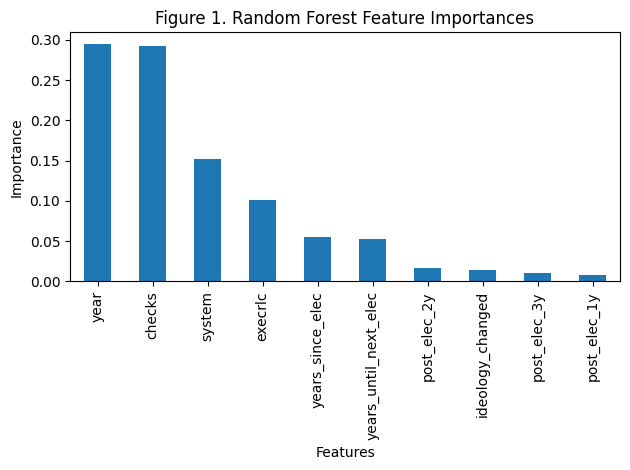

In [10]:
# Feature importances
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
ax = importances.plot(kind="bar")
ax.set_title("Figure 1. Random Forest Feature Importances")
ax.set_xlabel("Features")
ax.set_ylabel("Importance")
plt.tight_layout()
plt.show()

In [11]:
# Save predictions
pred_df = df.loc[test_mask, ["country","year"]].copy()
pred_df["y_true"] = y_test.values
pred_df["y_pred"] = y_pred
pred_df.to_csv("../data/test_predictions.csv", index=False)

## 11. Residual Analysis

After saving the model’s predictions, we evaluate residuals (the difference between actual and predicted UN alignment).  
Residual plots help identify whether the model systematically over- or under-predicts certain countries or periods.


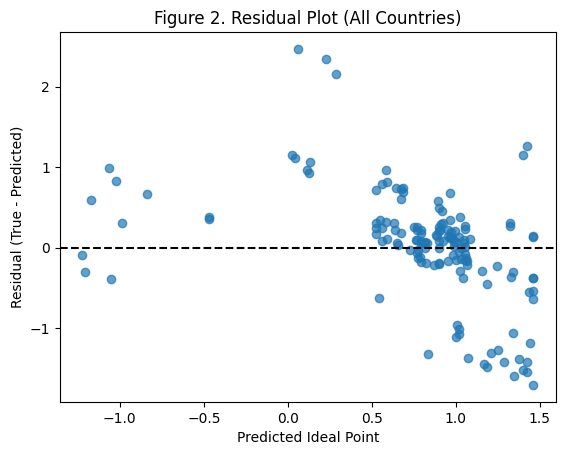

In [12]:
# 1. Load the saved predictions
res = pd.read_csv("../data/test_predictions.csv") 

# 2. Compute residuals
res["residual"] = res["y_true"] - res["y_pred"]

# 3. Overall scatter
plt.scatter(res["y_pred"], res["residual"], alpha=0.7)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted Ideal Point")
plt.ylabel("Residual (True - Predicted)")
plt.title("Figure 2. Residual Plot (All Countries)")
plt.show()

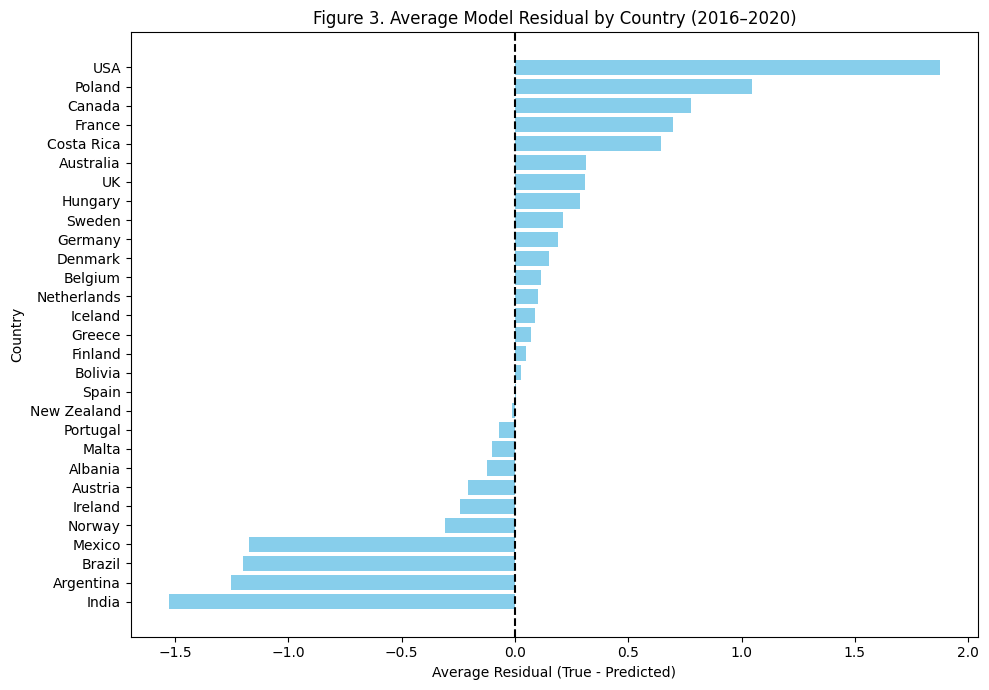

In [13]:
# 4. Average residual by country
country_res = res.groupby("country", as_index=False)["residual"].mean()
country_res = country_res.sort_values("residual")

plt.figure(figsize=(10,7))
plt.barh(country_res["country"], country_res["residual"], color="skyblue")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Average Residual (True - Predicted)")
plt.ylabel("Country")
plt.title("Figure 3. Average Model Residual by Country (2016–2020)")
plt.tight_layout()
plt.show()

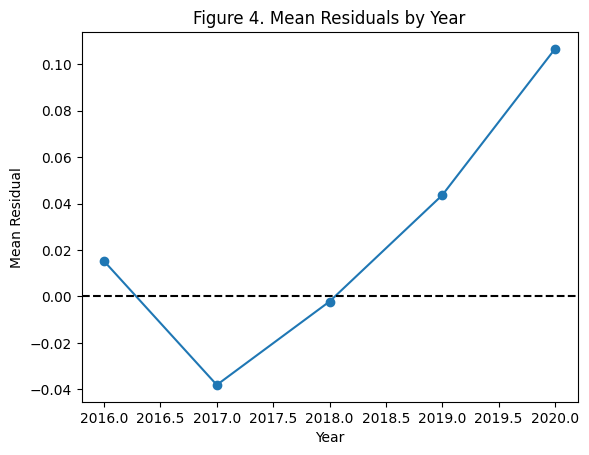

In [14]:
# 5. Average residual by year
year_res = res.groupby("year", as_index=False)["residual"].mean()
plt.plot(year_res["year"], year_res["residual"], marker="o")
plt.axhline(0, color="black", linestyle="--")
plt.title("Figure 4. Mean Residuals by Year")
plt.xlabel("Year")
plt.ylabel("Mean Residual")
plt.show()

## 12. Results and Discussion

### Model Performance
The Random Forest model achieved a test RMSE of **0.71** and an R² of **–0.08**, indicating limited predictive power.  
While the model captures broad tendencies, it performs only marginally better than random or mean-based prediction for out-of-sample years (2016–2020).  
This suggests that domestic political factors (ideology, institutional checks, and election timing) explain only a modest share of variation in countries’ UN alignment scores.

---

### Feature Importance (Figure 1)
**Figure 1** shows that `year` and `checks` were the most influential predictors, together accounting for more than half of the model’s total importance.  
The prominence of the `year` variable implies a strong **temporal trend** in UN voting alignment, likely reflecting post–Cold War realignment and gradual global polarization, rather than short-term electoral dynamics.  
Institutional constraints (`checks`) and system type also played moderate roles, suggesting that more stable institutional environments are associated with steadier foreign policy behavior.  
By contrast, the **low importance of `ideology_changed`** indicates that shifts in government ideology do not produce immediate or consistent changes in foreign policy alignment.  
This finding is consistent with the concept of path dependence in foreign policy, whereby established alliances, institutional commitments, and structural factors constrain the impact of short-term domestic political turnover.

---

### Residual Patterns by Country (Figures 2 & 3)
**Figure 2** plots residuals (actual – predicted values) for all test-country observations.  
The model performs reasonably well for mid-range states whose ideal points lie near the global mean but systematically **under-predicts** for highly Western-aligned countries and **over-predicts** for sovereignty-oriented or non-aligned states.  
This pattern reflects the model’s tendency to regress predictions toward the mean, a common property of ensemble methods when faced with extreme values.

**Figure 3** averages residuals by country, making this pattern more explicit.  
The model consistently underestimates alignment for countries such as **the United States, Poland, and Canada**, while overestimating it for **India, Argentina, Brazil, and Mexico**.  
These systematic errors highlight the limits of domestic-level explanations:  
states whose UN voting behavior is deeply rooted in **structural or geopolitical factors**—such as hegemonic status or regional autonomy—fall outside the model’s predictive scope.  
Conversely, European democracies with stable institutional patterns cluster near zero residuals, suggesting that domestic indicators better capture variation among those cases.

---

### Temporal Bias (Figure 4)
**Figure 4** shows mean residuals by year for the test period.  
Residuals increase steadily from 2016 to 2020, indicating that the model **increasingly under-predicted** actual UN alignment scores over time.  
This pattern suggests that global voting behavior shifted in the late 2010s in ways not captured by earlier domestic trends.  
One plausible interpretation is that the **rise of populist and nationalist governments** during this period—alongside widening geopolitical polarization—altered states’ engagement with the UN independently of conventional left-right ideology.  
Despite the model including a `year` variable, its linear treatment of time failed to capture this nonlinear structural break, pointing to a need for additional temporal or systemic features in future iterations.

---

### Overall Interpretation
Taken together, the results indicate that:
1. **Temporal and institutional factors** are more predictive of UN alignment than electoral or ideological turnover.  
2. **Foreign policy alignment is highly path-dependent**. In other words, states rarely shift course immediately after elections.  
3. **Systematic residuals** reveal structural divides between Western-aligned democracies and non Western-oriented or non-aligned states, showing the limits of domestic predictors.  
4. **Post-2016 drift** suggests a broader transformation in international politics—potentially linked to the populist wave and changing great-power relations—that domestic indicators alone cannot explain.

These findings contribute to the understanding of how domestic and systemic dynamics interact in shaping foreign policy.  
While domestic ideology provides only weak predictive power in the short term, the broader institutional and temporal context exerts stronger, more persistent influence on states’ UN voting behavior.


## Acknowledgments
This project was conducted as part of the **Directed Independent Research (DIR)** course within the **Council on International Educational Exchange (CIEE)** program in Berlin, Germany.  
I would like to express my sincere gratitude to **Dr. Christian Achrainer** for his guidance, feedback, and continued support throughout this research process.

## References
Voeten, Erik. 2009. *United Nations General Assembly Ideal Points.* [Harvard Dataverse](https://doi.org/10.7910/DVN/LEJUQZ). https://doi.org/10.7910/DVN/LEJUQZ


Inter-American Development Bank (IDB). 2023. *Database of Political Institutions (DPI).*  
https://www.iadb.org/en/knowledge-resources/research-idb/research-datasets/database-political-institutions

